In [93]:
%load_ext autoreload
%autoreload 2

%matplotlib inline



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from collections import deque
from io import StringIO
from IPython.display import display
from sklearn.metrics import log_loss, roc_auc_score, matthews_corrcoef

from sklearn import metrics
import graphviz

In [244]:
PATH = "data/bulldozers/"


In [263]:
#df_raw = pd.read_csv(f'{PATH}MFC18_EvalPart1.csv', low_memory=False, nrows=2)
with open(f'{PATH}MFC18_EvalPart1.csv', 'r') as f:
    q = deque(f, 100000)
df_raw = pd.read_csv(StringIO(''.join(q)), header=None)
df_raw.columns = pd.read_csv(f'{PATH}MFC18_EvalPart1.csv', header=0, nrows=1, index_col=None).columns

In [246]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [250]:
display_all(df_raw.tail().T)

,99995,99996,99997,99998,99999
p-uscisigradbased02a_0_2a_mediforsystem,255,255,255,255,255
p-binghamtonaggc_1_0_mediforsystem,255,255,255,255,255
p-purduepolimita11c_2_0_mediforsystem,255,255,255,255,255
p-noiseprintblindhq_1_1_mediforsystem,0,0,0,0,0
p-cresamplingdetector2st9wcm1mc_1_0_mediforsystem,17,16,16,14,13
p-kitwareberkeleyselfconsistency_84cd062_mediforsystem,255,255,255,255,255
p-ta11c_1_0_mediforsystem,0,0,0,0,0
p-purduepolimita11d_2_0_mediforsystem,255,255,255,255,255
p-cresamplingdetector2st8wcm1mc_1_0_mediforsystem,22,17,17,17,15
p-noiseprintblindpm_1_0_mediforsystem,255,255,255,255,255


In [102]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

In [103]:
df_raw = pd.read_feather('tmp/bulldozers-raw')

In [264]:
df, y, nas = proc_df(df_raw, 'label')

In [105]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

C:\Users\adibm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9037727671415758

In [265]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 120000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((80000, 29), (80000,), (20000, 29))

In [107]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [155]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\adibm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 2.76 s
[0.1322741106069666, 0.7924048312994229, 0.9051705455493904, -3.0881987024958812]


# Speeding things up

In [109]:
df_trn, y_trn, nas = proc_df(df_raw, 'label', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [110]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\adibm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 449 ms
[0.024484689093390584, 0.5286321184592048, 0.9969206028160125, -0.8194698322424947]


In [111]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.39725006365116977, 0.39505567343524745, 0.18940397113894225, -0.01614193078233983]


In [112]:
#draw_tree(m.estimators_[0], df_trn, precision=3)

# Bagging

In [113]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

C:\Users\adibm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.023801260470823808, 0.5164941916420747, 0.9970901109178832, -0.7368753448716472]


In [114]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0.]), 0.3, 1)

In [115]:
preds.shape

(10, 120000)

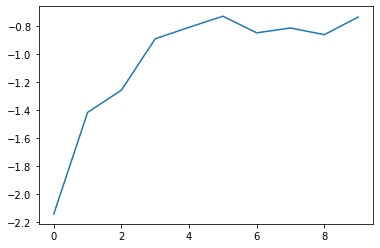

In [116]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

Shape of the curve suggests that adding more trees will not help that much

In [117]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.019605483926697653, 0.5289919856040669, 0.9980256158588904, -0.821947889317701]


In [118]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.016147755261955145, 0.5358743536657327, 0.9986606291647627, -0.8696646287702574]


In [119]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.014574699825382339, 0.53471409562728, 0.9989088718537241, -0.8615771173694857]


# Out-of-bag (OOB) score

In [120]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

C:\Users\adibm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.015949137907736582, 0.540691633658533, 0.9986933750480786, -0.9034306827658312, 0.7798474573685533]


# Reducing over-fitting
## Subsampling

In [121]:
df_trn, y_trn, nas = proc_df(df_raw, 'label')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)

In [122]:
set_rf_samples(20000)

In [123]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

C:\Users\adibm\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Wall time: 3.15 s
[0.1575462227296409, 0.7054626732388706, 0.8654729737152724, -2.24030466442802, 0.8592893100790485]


In [124]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1483359142956815, 0.7012266187427095, 0.88074236912991, -2.201507723225888, 0.8753183571997651]


## Tree building parameters

In [125]:
#min sample leaf
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.15578682787492643, 0.7299998180729733, 0.868460853201016, -2.469630847023152, 0.864710736410057]


In [126]:
# max features: the proportion of features to randomly select from at each split
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1594125196306821, 0.6475935372387371, 0.8622668740272568, -1.7305037574016473, 0.8585568523278648]


# Confidence based on tree variance

In [127]:
set_rf_samples(50000)

In [128]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13527253466553515, 0.6553847524833147, 0.9008225797870677, -1.796600513951066, 0.8941199004084408]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the relative confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [129]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

(0.3, 0.45825756949558394)


We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

## Feature Importance

In [130]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
27,image_id,0.286797
28,pixel_id,0.086346
16,p-plinearpattern1_1_0_mediforsystem,0.053111
4,p-cresamplingdetector2st9wcm1mc_1_0_mediforsystem,0.050283
18,p-kitwaredartmouthjpegdimples_0db8e4c_medifors...,0.048731
10,p-kitwarereflectionauthentication_dcd941a2_med...,0.046344
8,p-cresamplingdetector2st8wcm1mc_1_0_mediforsystem,0.042974
19,p-purdueta11bmfcn6april2018_1_0_mediforsystem,0.042708
1,p-binghamtonaggc_1_0_mediforsystem,0.038959
23,p-noiseprintblindall_1_0_mediforsystem,0.035939


In [131]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

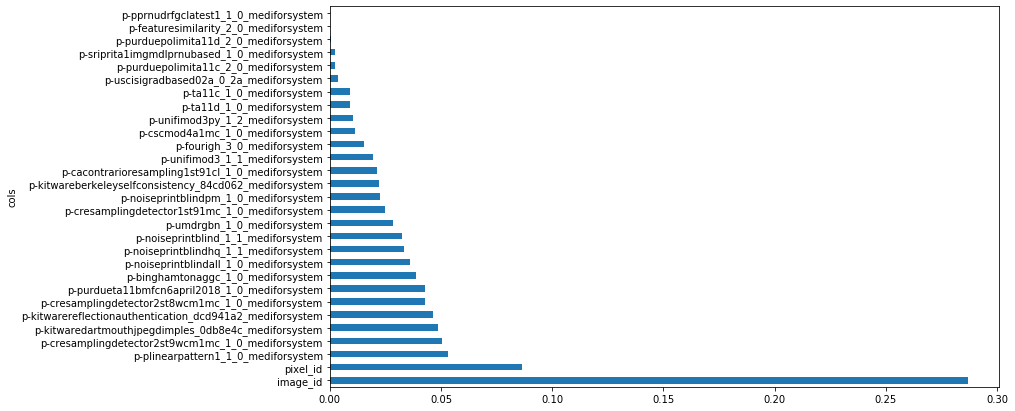

In [132]:
plot_fi(fi[:30]);

In [133]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

23

In [134]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [135]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.1359286008606749, 0.6301333778423672, 0.8998582341584719, -1.5852511243167697, 0.8930761373473801]


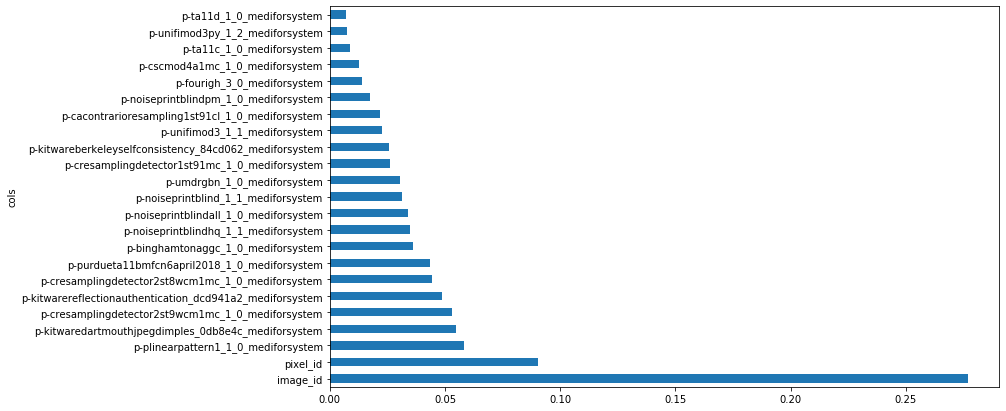

In [136]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

# Removing redundant features

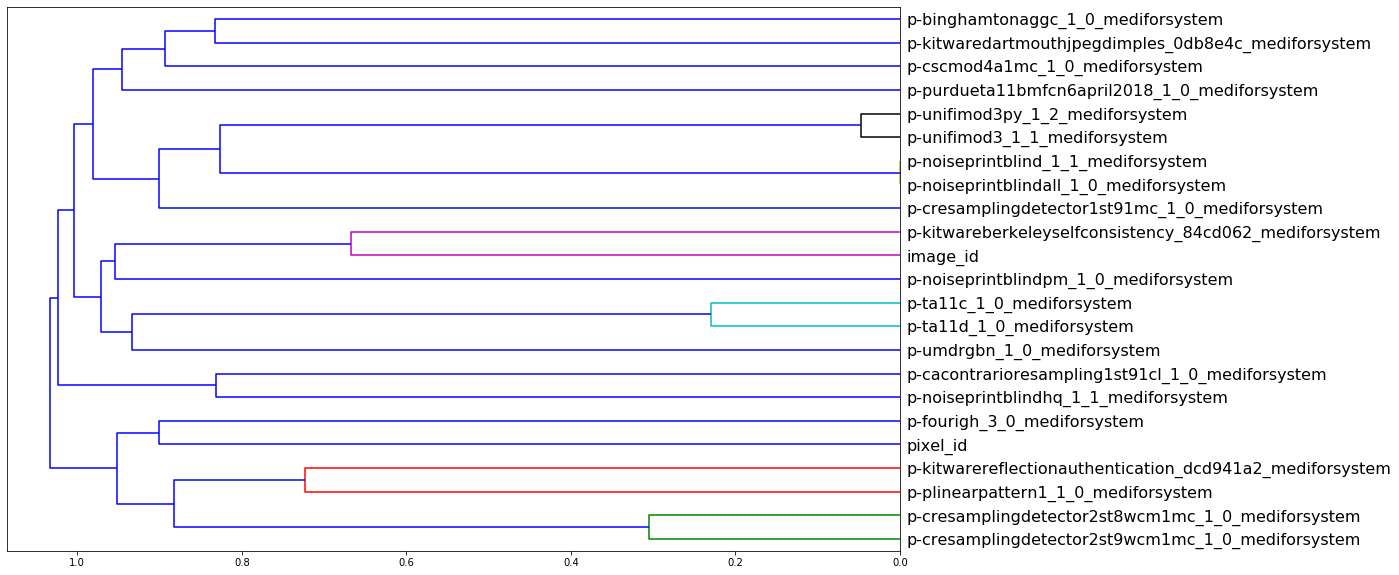

In [137]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [138]:

def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [139]:
#here is the baseline
get_oob(df_keep)

0.8856010147216021

In [140]:

for c in ('p-unifimod3py_1_2_mediforsystem', 'p-unifimod3_1_1_mediforsystem', 'p-ta11d_1_0_mediforsystem', 'p-ta11c_1_0_mediforsystem'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

p-unifimod3py_1_2_mediforsystem 0.8844218929072398
p-unifimod3_1_1_mediforsystem 0.8845735630220354
p-ta11d_1_0_mediforsystem 0.8846299544464519
p-ta11c_1_0_mediforsystem 0.8844639536558786


## Removing features that are highly correlated

In [141]:
to_drop = ['p-unifimod3_1_1_mediforsystem', 'p-ta11c_1_0_mediforsystem']
get_oob(df_keep.drop(to_drop, axis=1))

0.8842092218194745

In [142]:

df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [143]:
#lets run this model on the full sample
reset_rf_samples()

In [144]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.06331587621552598, 0.6761094782100888, 0.978272047925972, -1.976266492559032, 0.946629352074586]


## Removing pixel_id and image_id

In [146]:
df_subs = df_keep.drop(['image_id', 'pixel_id'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.183238115546621, 0.3758668373396181, 0.8180193610819014, 0.08017377844754003, 0.8061232349483263]


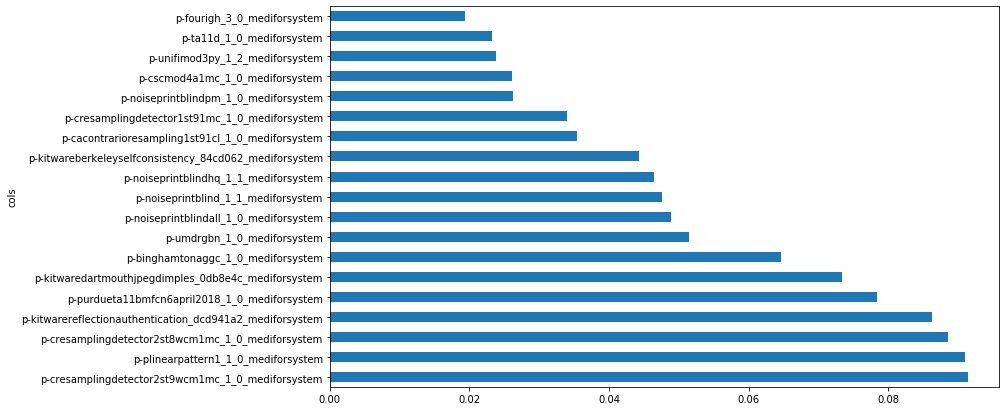

In [147]:
plot_fi(rf_feat_importance(m, X_train));

In [150]:
np.save('tmp/subs_cols.npy', np.array(df_subs.columns))

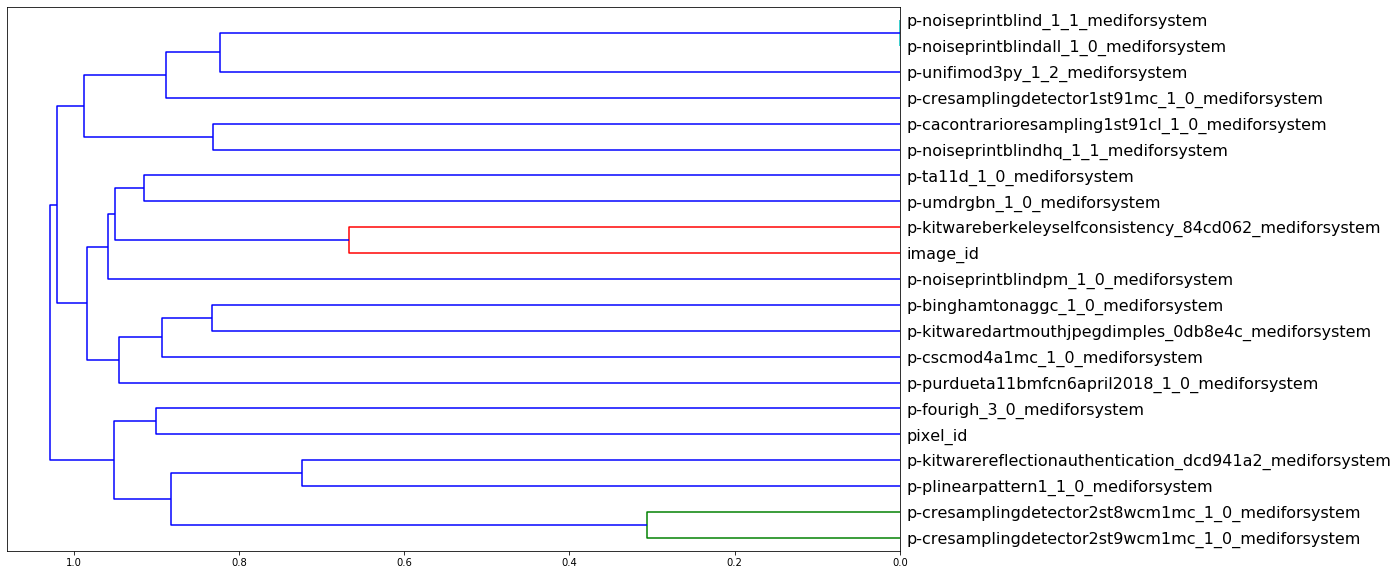

In [151]:
from scipy.cluster import hierarchy as hc

corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

# Our own metrics

In [176]:
def print_our_scores(m):
    result = {
        'log_loss':log_loss(y_valid , m.predict(X_valid)),
        'auroc_score': roc_auc_score(y_valid , m.predict(X_valid)),
        'mcc' : matthews_corrcoef(y_valid, np.where(m.predict(X_valid) > 0.5, 1, 0))
    }
    for key,value in result.items():
        print(key,':',value)

# Final Model

In [262]:
m = RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)
print_our_scores(m)

Wall time: 5min 29s
[0.29123600598184446, 0.44732482386614203, 0.5475980179250137, -0.15711947560303252, 0.5457680555447415]
log_loss : 0.584680249275123
auroc_score : 0.6132475614175157
mcc : 0.12451561357274249


## Results

With the first 1,000,000 rows of data, the following scores were achieved <br>

  log_loss : 1.0292556445831305 <br>
  auroc_score : 0.5852987969755649  <br>
  mcc : -0.05773411379007237 <br>

With the first 10,000,000 rows of data, the following scores were achieved <br>

  log_loss : 0.5585351179094766  <br>
  auroc_score : 0.6800033905087887 <br>
  mcc : 0.29742184664509985 <br>
  
With the last 1,000,000 rows of data, the following scores were achieved <br>  
  log_loss : 0.6399277750386689
  auroc_score : 0.47267329914298756
  mcc : -0.05691881284353903
  
With the last 10,000,000 rows of data, the following scores were achieved <br>
  log_loss : 0.584680249275123
  auroc_score : 0.6132475614175157
  mcc : 0.12451561357274249
